In [ ]:
pip -q install qiskit

     |████████████████████████████████| 6.5 MB 4.8 MB/s 
     |████████████████████████████████| 18.0 MB 229 kB/s 
     |████████████████████████████████| 240 kB 45.3 MB/s 
     |████████████████████████████████| 200 kB 40.4 MB/s 
     |████████████████████████████████| 112 kB 34.3 MB/s 
     |████████████████████████████████| 54 kB 2.0 MB/s 
     |████████████████████████████████| 1.6 MB 36.8 MB/s 
     |████████████████████████████████| 49 kB 1.5 MB/s 
     |████████████████████████████████| 37.5 MB 1.3 MB/s 
     |████████████████████████████████| 943 kB 55.4 MB/s 
     |████████████████████████████████| 49 kB 4.0 MB/s 
     |████████████████████████████████| 38.1 MB 1.3 MB/s 
     |████████████████████████████████| 3.6 MB 37.2 MB/s 
     |████████████████████████████████| 113 kB 47.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.1

In [ ]:
pip -q install pylatexenc

     |████████████████████████████████| 162 kB 5.2 MB/s 


In [ ]:
pip -q install ibm_quantum_widgets

     |████████████████████████████████| 993 kB 5.6 MB/s 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits import mplot3d
import mpl_toolkits.mplot3d.art3d as art3d
from qiskit import *
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
import random
#from keras.datasets import mnist
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
import tensorflow as tf

In [ ]:
def stateprep(x_train, y_train, x_test, d):

  """
  x_train: array of training features (n_samples, 2)
  y_train: array of binary training labels (n_samples, )
  x_test: array of test features (2, )
  d: number of control qubits. Generates 2^d transformations to training data
  """

  N = x_train.shape[0]

  control_reg = QuantumRegister(max(d, 1), 'control')
    
  x_train_reg = QuantumRegister(N, 'x_train')
  y_train_reg = QuantumRegister(N, 'y_train')
  x_test_reg = QuantumRegister(1, 'x_test')
  prediction_reg = QuantumRegister(1, 'prediction')
  cr = ClassicalRegister(1, name = "cr")



  stateprep = QuantumCircuit(control_reg, x_train_reg, y_train_reg, x_test_reg, prediction_reg, cr)

  #create uniform superposition of control qubits
  for i in range(d):
    stateprep.h(control_reg[i])


  #initialize training data
  for i in range(x_train.shape[0]):
    stateprep.initialize(x_train[i]/np.linalg.norm(x_train[i]), i+d)

  for i in range(y_train.shape[0]):
    if y_train[i] == 1:
      stateprep.initialize([0, 1], i+d+x_train.shape[0])
    else:
      stateprep.initialize([1, 0], i+d+x_train.shape[0])

  #initialize test data
  stateprep.initialize(x_test/np.linalg.norm(x_test), d+2*N)


  stateprep.barrier()

  return stateprep

def superposition_sampler(N, d):

    """
    x_train: array of training features
    y_train: array of binary training labels
    x_test: array of test features
    d: number of control qubits. Generates 2^d transformations to training data
    """

    control_reg = QuantumRegister(max(d,1), 'control')
    x_train_reg = QuantumRegister(N, 'x_train')
    y_train_reg = QuantumRegister(N, 'y_train')
    x_test_reg = QuantumRegister(1, 'x_test')
    prediction_reg = QuantumRegister(1, 'prediction')
    cr = ClassicalRegister(1, name = "cr")


    sampler = QuantumCircuit(control_reg, x_train_reg, y_train_reg, x_test_reg, prediction_reg, cr)


    for i in range(d):
        l, m = random.sample(range(0,N), 2)
        lp, mp = random.sample(range(0,N), 2)

        sampler.cswap(control_reg[i], x_train_reg[l], x_train_reg[m])
        sampler.cswap(control_reg[i], y_train_reg[l], y_train_reg[m])
        sampler.x(i)
        sampler.cswap(control_reg[i], x_train_reg[lp], x_train_reg[mp])
        sampler.cswap(control_reg[i], y_train_reg[lp], y_train_reg[mp])
        sampler.barrier()


    return sampler

def cosine_classifier(N, d):

  """
  N: number of train samples
  d: number of control qubits. Generates 2^d transformations to training data
  """
  control_reg = QuantumRegister(max(d,1), 'control')
  x_train_reg = QuantumRegister(N, 'x_train')
  y_train_reg = QuantumRegister(N, 'y_train')
  x_test_reg = QuantumRegister(1, 'x_test')
  prediction_reg = QuantumRegister(1, 'prediction')
  cr = ClassicalRegister(1, name = "cr")



  f = QuantumCircuit(control_reg, x_train_reg, y_train_reg, x_test_reg, prediction_reg, cr)
  f.h(prediction_reg[0])

  k = random.sample(range(0, N), 1)

  f.cswap(prediction_reg[0], x_train_reg[k], x_test_reg[0])
  f.h(prediction_reg[0])
  f.cx(y_train_reg[k], prediction_reg[0])
  f.barrier()
  
  return f

def measure(N, d):
    """
    N: number of train samples
    d: number of control qubits. Generates 2^d transformations to training data
    """
        
    control_reg = QuantumRegister(max(d,1), 'control')
    x_train_reg = QuantumRegister(N, 'x_train')
    y_train_reg = QuantumRegister(N, 'y_train')
    x_test_reg = QuantumRegister(1, 'x_test')
    prediction_reg = QuantumRegister(1, 'prediction')
    cr = ClassicalRegister(1, name = "cr")
    
    m = QuantumCircuit(control_reg, x_train_reg, y_train_reg, x_test_reg, prediction_reg, cr)
    m.measure(prediction_reg[0], cr[0])
    
    return m

def plot_data(x_train, y_train, x_test):
    '''
    x_train: (n_samples, 2)
    y_train: (n_samples, )
    x_test: (2, )
    '''

    cdict = {0: 'red', 1: 'blue'}

    fig, ax = plt.subplots()
    for g in np.unique(y_train):
        ix = np.where(y_train == g)
        ax.scatter(x_train[ix, 0], x_train[ix, 1], c = cdict[g], label = int(g))
    ax.scatter(x_test[0], x_test[1], color='green')
    ax.legend()
    
    plt.xlim([-2,2])
    plt.ylim([-2,2])
    plt.show()

    """

    x_test = x_test[np.newaxis, :]
    x = np.concatenate((x_train, x_test), axis = 0)
    y = np.concatenate((y_train, np.asarray([-1])), axis = 0)
    
    data = pd.DataFrame(columns = ['x1', 'x2', 'y'])
    data['x1'] = x[:, 0]
    data['x2'] = x[:, 1]
    data['y'] = y
    
    sns.catplot(x='x1', y='x2', hue='y', data=data)
    
    return

    """

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_X, train_y), (test_X, test_y) = fashion_mnist.load_data()

In [ ]:
def process_data(train_X, train_y, test_X, test_y):
    #take only the values of y that are 9 or 0 and apply filter
    filter_train = (train_y == 9) + (train_y == 0)
    train_y = train_y[filter_train]
    train_X = train_X[filter_train]


    filter_test = (test_y == 9) + (test_y == 0)
    test_y = test_y[filter_test]
    test_X = test_X[filter_test]
    
    #Convert to 1s or 0s
    train_y = (train_y == 9)
    test_y = (test_y == 9)
    
    #vectorize matrices
    train_X = train_X.reshape(train_X.shape[0], -1)
    test_X = test_X.reshape(test_X.shape[0], -1)
    
    #apply standardization
    
    train_X = StandardScaler().fit_transform(train_X)
    test_X = StandardScaler().fit_transform(test_X)
    

    
    #apply PCA
    pca = PCA(n_components = 2, svd_solver='full')
    pca.fit(train_X)
    train_X = pca.transform(train_X)
    test_X = pca.transform(test_X)
    
    #Apply a uniform shift to the data (works better with cosine classifier)
    
    train_X = train_X + np.array([0, 20])
    test_X = test_X + np.array([0, 20])
    
    #return transformed data
    
    return train_X, train_y, test_X, test_y

In [ ]:
def subsample(train_X, train_y, train_sample_sz):
    #Take a sample of training data and make sure each label is equally represented
    #sample_indices = np.random.randint(low=0,high=train_X.shape[0], size=train_sample_sz)
    #train_X = train_X[sample_indices]
    #train_y = train_y[sample_indices]

    accumulated_sz = 0
    ones_count = 0
    zeros_count = 0
    new_train_y = []
    new_train_x = []

    while(accumulated_sz < train_sample_sz):
      idx = np.random.randint(0, train_X.shape[0], 1)
      x = train_X[idx]
      y = train_y[idx]
      if(ones_count > zeros_count and y == 0):
        new_train_y.append(y)
        new_train_x.append(x)
        accumulated_sz += 1
        zeros_count += 1
      elif(zeros_count > ones_count and y == 1):
        new_train_y.append(y)
        new_train_x.append(x)
        accumulated_sz += 1
        ones_count += 1
      elif(zeros_count == ones_count):
        if y==1: ones_count += 1
        else: zeros_count += 1
        new_train_y.append(y)
        new_train_x.append(x)
        accumulated_sz += 1
    train_X = np.array(new_train_x).reshape(train_sample_sz, -1)
    train_y = np.array(new_train_y).reshape(train_sample_sz)
    
    #return subsample
    return train_X, train_y

In [ ]:
train_sample_sz = 1 #use a subset of training data
d = 0 #number of control registers

#Process data
train_X, train_y, test_X, test_y = process_data(train_X, train_y, test_X, test_y)
test_X = test_X[:120]
test_y = test_y[:120]
n_test = test_X.shape[0]

In [ ]:
test_y.shape

(120,)

In [ ]:

accuracy = []

for itr in range(10):
    predictions = np.empty(n_test)

    sample_train_X, sample_train_y = subsample(train_X, train_y, train_sample_sz)
    
    ss = superposition_sampler(train_sample_sz, d)
    cc = cosine_classifier(train_sample_sz, d)
    m = measure(train_sample_sz, d)
    
    for i in range(n_test):
        circ = stateprep(sample_train_X, sample_train_y, test_X[i], d)
        circ.compose(ss, inplace=True)
        circ.compose(cc, inplace=True)
        circ.compose(m, inplace=True)
        res = execute(circ, Aer.get_backend('qasm_simulator'), shots=100).result().get_counts()
        predictions[i] = int(max(res, key=res.get))
    accuracy.append(accuracy_score(predictions, test_y))

print(f'Average accuracy for d={d}, N={train_sample_sz}: {np.mean(accuracy)}')

Average accuracy for d=0, N=1: 0.5158333333333334


In [ ]:
sample_train_X = normalize(sample_train_X, norm="l2")
test_X = normalize(test_X, norm="l2")

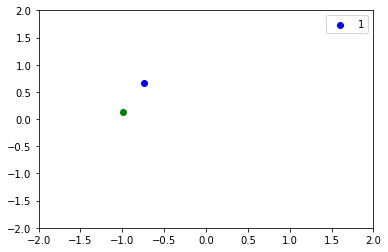

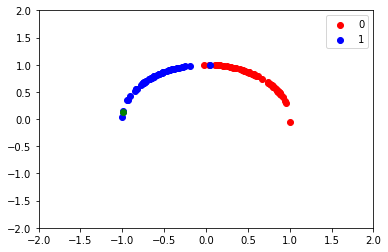

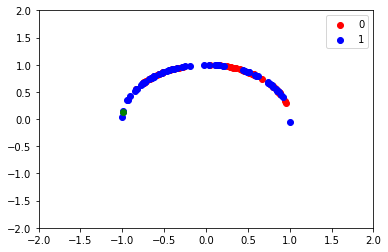

In [ ]:
plot_data(sample_train_X, sample_train_y, test_X[i])
plot_data(test_X, test_y, test_X[i])
plot_data(test_X, predictions, test_X[i])

In [ ]:
np.std(accuracy)

0.03826987501068344